## Retreive Data from Database

In [ ]:
import sqlite3 as sql

path = "data.sqlite"

conn = sql.connect(path)
cur = conn.cursor()

firstquery = pd.read_sql_query("SELECT name, mt_dna, length FROM MtDNA", conn)

conn.close()


## Edit Distance & Molecular Clock

In [3]:
import numpy as np
import edlib

df = firstquery

names = df['name']
hominoids = {names[i]: df['mt_dna'][i] for i in range(len(names))}

### Using the dictionary, we iteratively run edit distance on every combination of species.
### First set up matrix for edit distances
ds_mat = np.zeros((len(names), len(names)))

for i in range(len(names)):
    for j in range(i + 1, len(names)):
        result = edlib.align(hominoids[names[i]], hominoids[names[j]], task='distance')
        edit_ds = result['editDistance']
        ds_mat[i, j] = ds_mat[j, i] = edit_ds

### Reset the names here so that matching order remains corect
names = ['European Neanderthal', 'Altai Denisovan', 'Sumatran Orangutan',
         'Bornean Orangutan', 'Western Lowland Gorilla', 'Eastern Lowland Gorilla', 'Bonobo',
         'Chimp Schweinfurthii', 'Chimp Ellioti', 'Chimp Verus', 'Chimp Troglodytes',
         'Hoolock Gibbon', 'Symphalangus Gibbon', 'Nomascus Gibbon', 'Hylobates Gibbon']


extract1 = ds_mat[1]
extract2 = np.array([extract1[i] for i in range(len(extract1)) if i != 1])

data = pd.DataFrame({'Species': names, 'Edit Distance': extract2})

nuclear_lower = [0.6, 0.6, 12, 12, 8, 8, 6, 6, 6, 6, 6, 16, 16, 16, 16]
nuclear_upper = [0.8, 0.8, 15, 15, 10, 10, 8, 8, 8, 8, 8, 20, 20, 20, 20]

data['Nuclear Lower Bound'] = nuclear_lower
data['Nuclear Upper Bound'] = nuclear_upper



avg_length = np.mean(df['length'])

def clock(c, L):
    time = (-3/4)*(np.log(1-((4/3)*(c/L))))
    return time

mitochondrial = []

for dist in data['Edit Distance']:
    d = clock(dist, avg_length)
    r = 0.015
    t = d/r
    mitochondrial.append(t)
    
data['Mitochondrial Date'] = mitochondrial

data = data.sort_values('Edit Distance')

data


,Species,Edit Distance,Nuclear Lower Bound,Nuclear Upper Bound,Mitochondrial Date
0,European Neanderthal,215.0,0.6,0.8,0.875632
1,Altai Denisovan,392.0,0.6,0.8,1.608191
10,Chimp Troglodytes,2462.0,6.0,8.0,11.081883
7,Chimp Schweinfurthii,2487.0,6.0,8.0,11.208016
6,Bonobo,2491.0,6.0,8.0,11.228227
9,Chimp Verus,2491.0,6.0,8.0,11.228227
8,Chimp Ellioti,2492.0,6.0,8.0,11.233281
4,Western Lowland Gorilla,2679.0,8.0,10.0,12.187474
5,Eastern Lowland Gorilla,2699.0,8.0,10.0,12.290613
3,Bornean Orangutan,3276.0,12.0,15.0,15.361655


## Plotting Molecular Clock

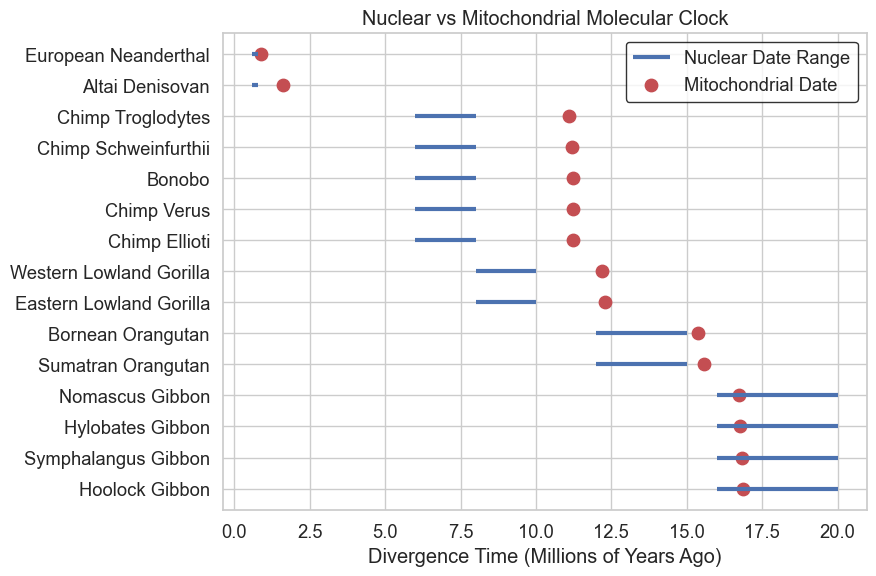

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(9, 6))
y = range(len(data))

### nuclear
ax.hlines(
    y,
    data["Nuclear Lower Bound"],
    data["Nuclear Upper Bound"],
    color="C0",
    linewidth=3,
    label="Nuclear Date Range"
)

### mitochondrial
ax.scatter(
    data["Mitochondrial Date"],
    y,
    color="C3",
    marker="o",
    s=80,
    label="Mitochondrial Date"
)

### names on y axis
ax.set_yticks(y)
ax.set_yticklabels(data["Species"])

ax.set_xlabel("Divergence Time (Millions of Years Ago)")
ax.set_title("Nuclear vs Mitochondrial Molecular Clock")

ax.invert_yaxis()
ax.legend().get_frame().set_edgecolor("black")
plt.tight_layout()
plt.show()


## Linear Regression

In [5]:
x = data[['Nuclear Lower Bound', 'Nuclear Upper Bound']].mean(axis=1)
y = data["Mitochondrial Date"]

m, b = np.polyfit(x, y, 1)
y_pred = m*x + b

ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res/ss_tot)

print(r2)

0.8632816043725575
